## Section 2. Data Understanding
### 2.1 Dataset Information

In [128]:
import os
import warnings
from pathlib import Path

# Disable LOKY debug logs
os.environ["LOKY_DEBUG"] = "0"

# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Model explainability
import lime.lime_tabular

# Imbalanced-learn (sampling)
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import (
    ADASYN,
    BorderlineSMOTE,
    KMeansSMOTE,
    RandomOverSampler,
    SMOTE,
    SMOTENC,
    SMOTEN,
    SVMSMOTE,
)
from imblearn.pipeline import Pipeline as ImbPipeline

# Scikit-learn
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import (
    AdaBoostClassifier,
    BaggingClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    StackingClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    # accuracy_score,
    # brier_score_loss,
    classification_report,
    confusion_matrix,
    # f1_score,
    precision_recall_curve,
    # precision_score,
    recall_score,
    # roc_auc_score,
    # roc_curve,
)
from sklearn.model_selection import (
    StratifiedKFold,
    RandomizedSearchCV,
    cross_val_score,
    learning_curve,
    train_test_split,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    RobustScaler,
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

# Gradient boosting frameworks
from xgboost import XGBClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier

# Joblib for model persistence
import joblib


# Suppress all warnings
warnings.filterwarnings("ignore")

# Set pandas display options for better visibility
pd.set_option("display.max_columns", None)

# Set Seaborn theme for better aesthetics
sns.set_theme()


data_path = Path("../data/WA_Fn-UseC_-Telco-Customer-Churn.csv")

if data_path.exists():
    real_df = pd.read_csv(data_path)
    df = real_df.copy()
    print(df.info())
    display(df.head())
else:
    print(f"File not found: {data_path}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Komposisi dataset berbeda, di mana luasnya naik. Sebelumnya sekitar 4900 baris dan 11 kolom, sekarang 7043 baris dan 21 kolom.

Ntar copas dari kaggle aja.

### 2.2 Missing Values Checking

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


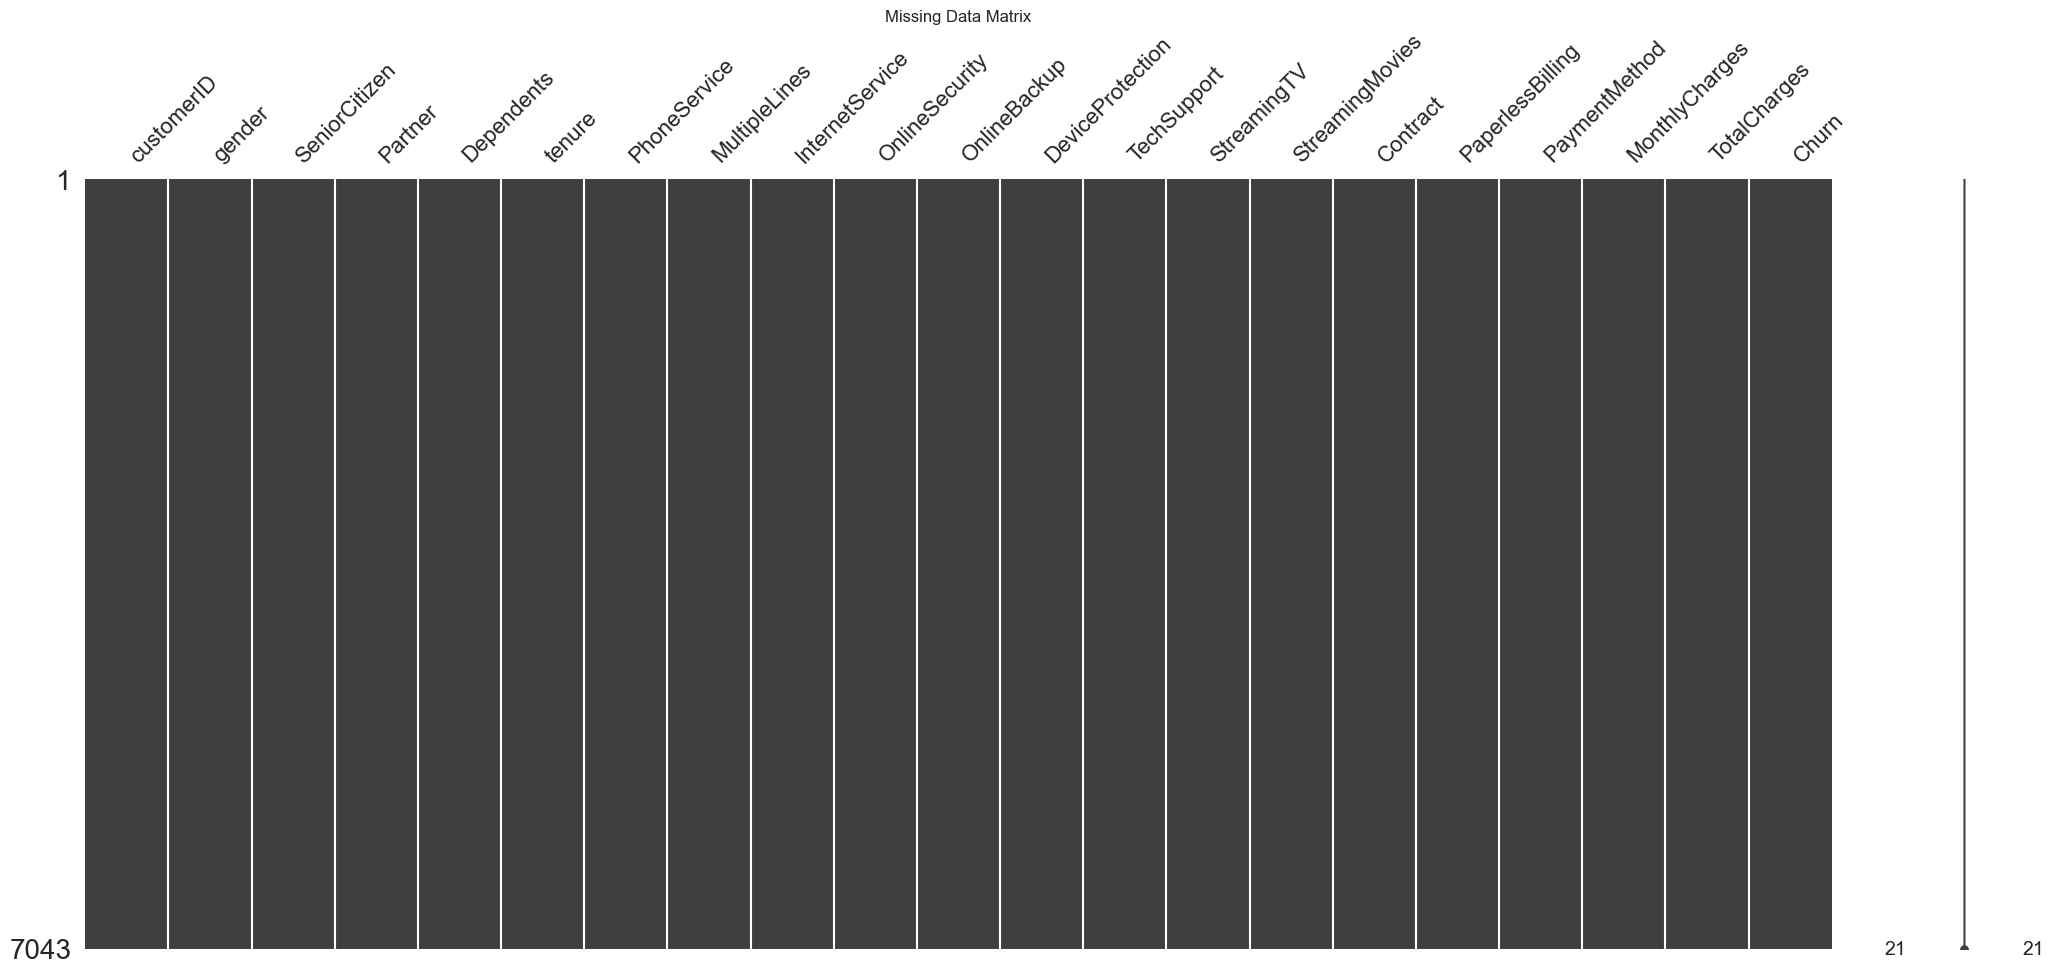

In [113]:
# Check missing values count per column
missing_counts = df.isnull().sum()
print(missing_counts)

# Visualize missing data pattern
msno.matrix(df)
plt.title('Missing Data Matrix')
plt.show()

Gak ada missing values di sini.

### 2.3 Duplicated Values Checking

In [114]:
# Count duplicated rows
num_duplicates = df.duplicated().sum()
print(f"Number of duplicated rows: {num_duplicates}")

Number of duplicated rows: 0


Gak ada duplikat di sini.

### 2.4 Dataset Restructuring for Better EDA

In [115]:
# Convert object columns to category dtype
object_cols = df.select_dtypes(include=['object']).columns.tolist()
object_cols = [col for col in object_cols if col not in ('customerID', 'TotalCharges')]
df[object_cols] = df[object_cols].astype('category')
df['SeniorCitizen'] = df['SeniorCitizen'].map({0: 'No', 1: 'Yes'}).astype('category')
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Confirm changes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7043 non-null   object  
 1   gender            7043 non-null   category
 2   SeniorCitizen     7043 non-null   category
 3   Partner           7043 non-null   category
 4   Dependents        7043 non-null   category
 5   tenure            7043 non-null   int64   
 6   PhoneService      7043 non-null   category
 7   MultipleLines     7043 non-null   category
 8   InternetService   7043 non-null   category
 9   OnlineSecurity    7043 non-null   category
 10  OnlineBackup      7043 non-null   category
 11  DeviceProtection  7043 non-null   category
 12  TechSupport       7043 non-null   category
 13  StreamingTV       7043 non-null   category
 14  StreamingMovies   7043 non-null   category
 15  Contract          7043 non-null   category
 16  PaperlessBilling  7043 n

The DataFrame is restructured for better Exploratory Data Analysis (EDA) because the initial data types are not relevant. This restructuring is performed to enhance the efficiency and clarity of the data, which is crucial for effective analysis. The object columns are converted to categorical data type, a process that is often necessary to ensure that the data is properly formatted for statistical and machine learning tasks (McKinney, 2017; VanderPlas, 2016).

The conversion of object columns to categorical data type is achieved by using the astype('category') method in Pandas. This approach not only improves memory efficiency but also ensures that the data is treated appropriately during analysis. The changes are confirmed by checking the updated data types of the DataFrame using the info() method, which provides a summary of the DataFrame's structure and memory usage (McKinney, 2017; VanderPlas, 2016).

The restructuring process is facilitated by identifying the object columns and applying the necessary conversion. This step is essential in maintaining data integrity and ensuring that the analysis is conducted on the correct data types. The use of categorical data types can also help in reducing errors that might arise from treating categorical variables as strings (Wickham & Grolemund, 2017; McKinney, 2017).

### 2.5 Exploratory Data Analysis (EDA)

#### 2.5.1 Statistics Summary

In [116]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
tenure,7043.0,32.371149,24.559481,0.00,9.00,29.000,55.0000,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.50,70.350,89.8500,118.75
TotalCharges,7032.0,2283.300441,2266.771362,18.80,401.45,1397.475,3794.7375,8684.80


...

In [117]:
df.describe(include=['object','category']).transpose()

,count,unique,top,freq
customerID,7043,7043,7590-VHVEG,1
gender,7043,2,Male,3555
SeniorCitizen,7043,2,No,5901
Partner,7043,2,No,3641
Dependents,7043,2,No,4933
PhoneService,7043,2,Yes,6361
MultipleLines,7043,3,No,3390
InternetService,7043,3,Fiber optic,3096
OnlineSecurity,7043,3,No,3498
OnlineBackup,7043,3,No,3088


...

#### 2.5.2 Proportion Analysis

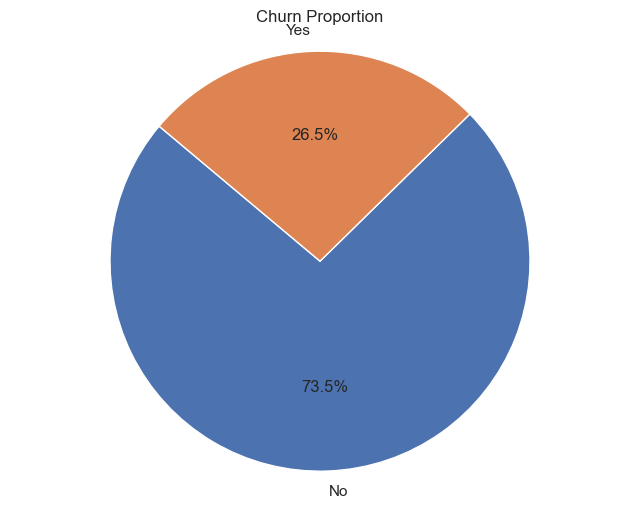

In [118]:
churn_proportion = df['Churn'].value_counts(normalize=True) * 100

plt.figure(figsize=(8, 6))
plt.pie(churn_proportion, labels=churn_proportion.index, autopct='%1.1f%%', startangle=140)
plt.title('Churn Proportion')
plt.axis('equal')  # Equal aspect ratio ensures pie chart is circular
plt.show()

Masih imbalanced, karena thresholdnya 70:30.

#### 2.5.3 Boxplot Analysis

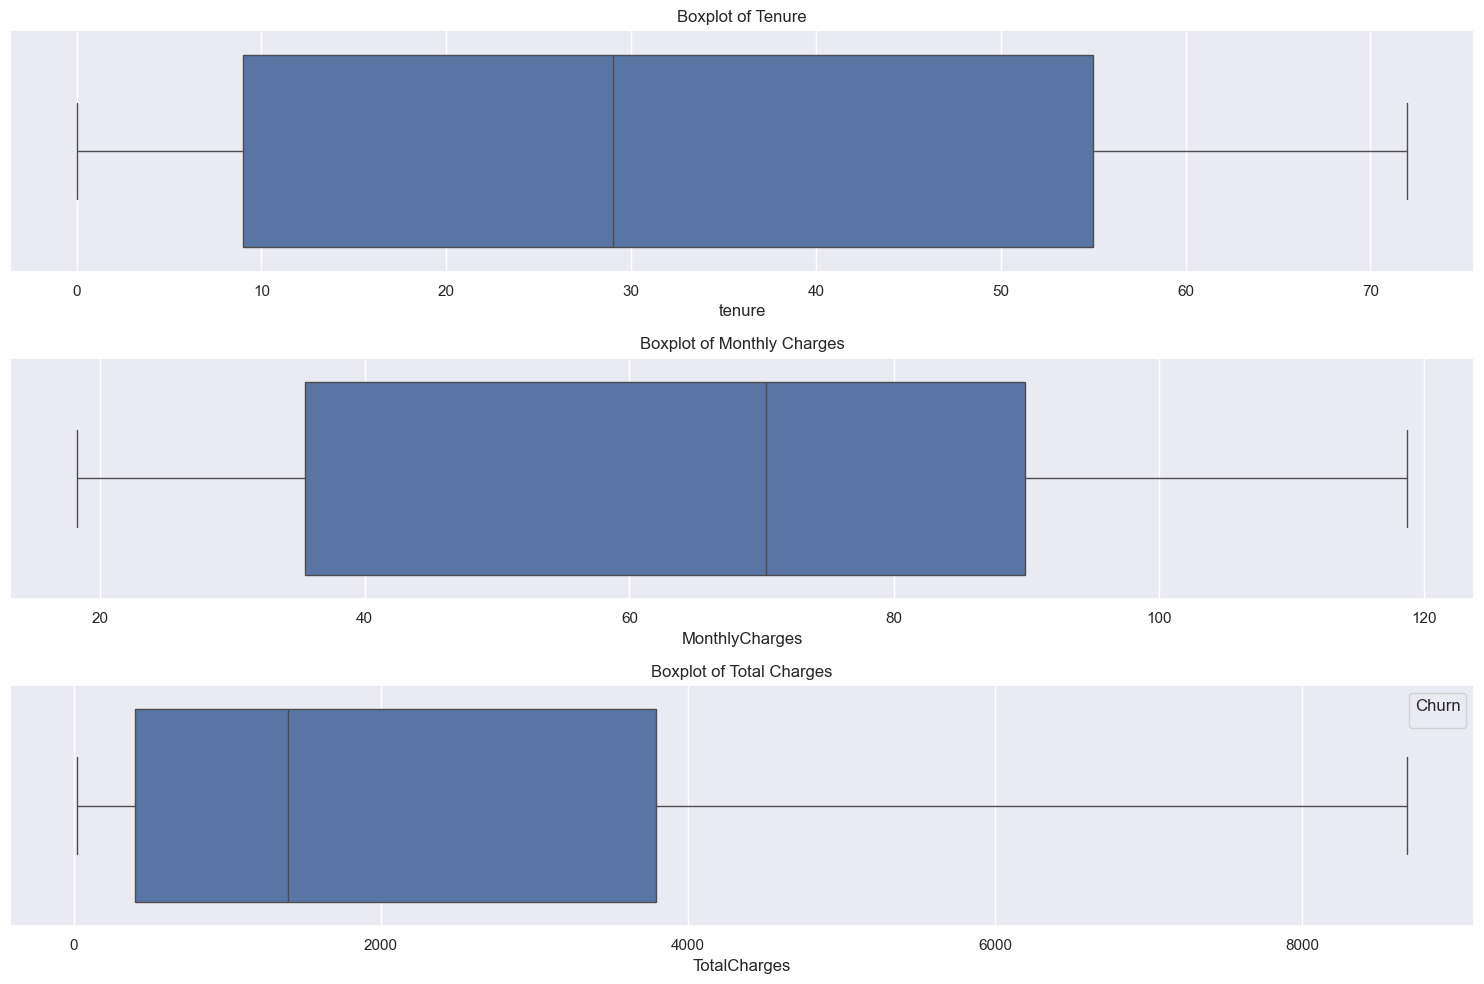

In [119]:
# Select numeric columns
numerics = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Create subplots: 3 rows, 3 columns
fig, axes = plt.subplots(3, 1, figsize=(15, 10))
axes = axes.flatten()

# 1st subplot: Boxplot of 'tenure'
sns.boxplot(x=df['tenure'], orient='h', ax=axes[0])
axes[0].set_title('Boxplot of Tenure')

# 2nd subplot: Boxplot of 'MonthlyCharges'
sns.boxplot(x=df['MonthlyCharges'], orient='h', ax=axes[1])
axes[1].set_title('Boxplot of Monthly Charges')

# 3rd subplot: KDE plot for 'tenure' by 'Churn'
sns.boxplot(x=df['TotalCharges'], orient='h', ax=axes[2])
axes[2].set_title('Boxplot of Total Charges')
axes[2].legend(title='Churn')

# Adjust layout
plt.tight_layout()
plt.show()

Masih sama, distribusinya gak normal.

#### 2.5.4 Correlation Analysis

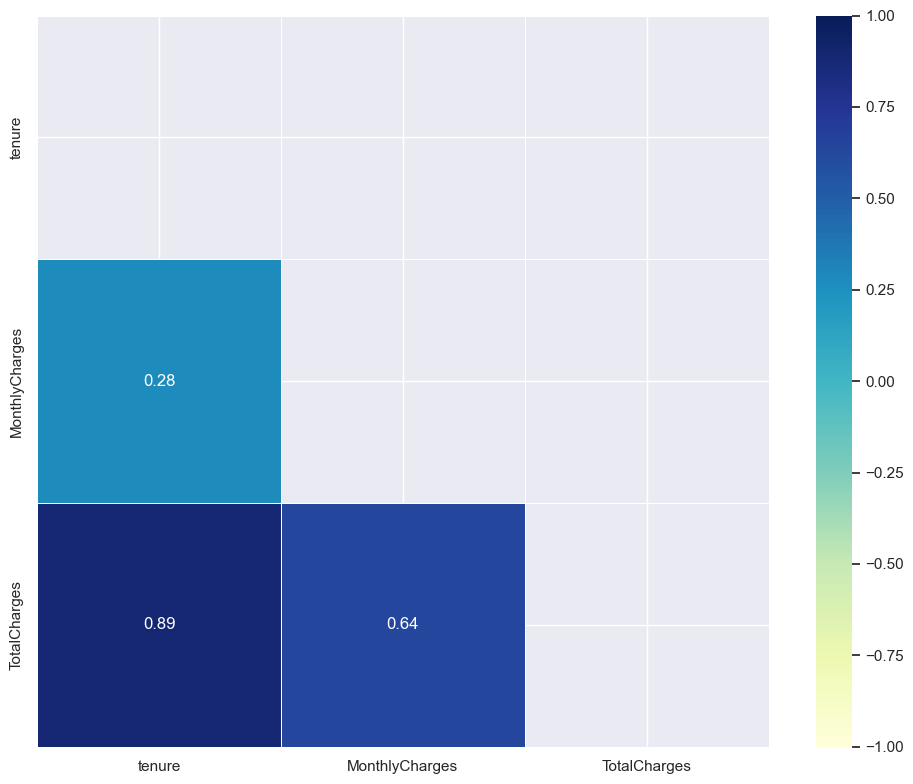

In [120]:
# Compute Spearman correlation matrix for numeric columns
corr = df.corr(numeric_only=True, method='spearman')

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10, 8))

# 1st subplot: KDE plot for 'tenure' by 'Churn'
sns.heatmap(corr, mask=mask, annot=True, cmap='YlGnBu', vmin=-1, vmax=1, square=True, linewidths=0.5)

# Adjust layout
plt.tight_layout()
plt.show()

#### 2.5.5 Pairplot Analysis

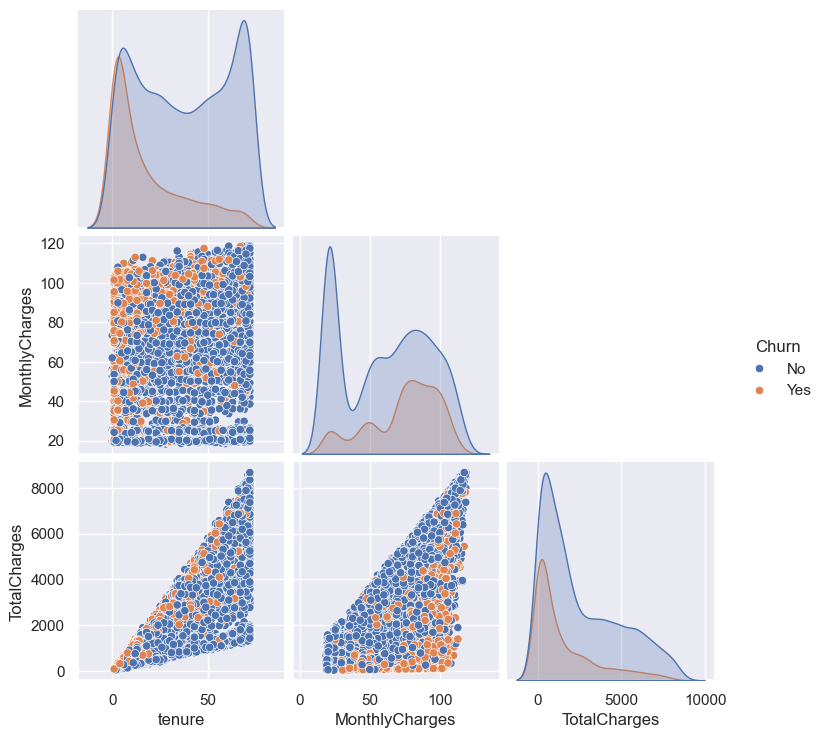

In [121]:
sns.pairplot(df, corner=True, hue='Churn');

...

#### 2.5.6 Unique Values Analysis

In [122]:
cat_cols = df.select_dtypes(include=['category']).columns

# Dictionary of unique counts per categorical column
unique_counts = {col: df[col].nunique() for col in cat_cols}

# Dictionary of unique values lists per categorical column
unique_values_list = {col: df[col].unique().tolist() for col in cat_cols}

unique_summary = pd.DataFrame({'unique_counts': unique_counts, 'unique_values': unique_values_list})
unique_summary

,unique_counts,unique_values
gender,2,"[Female, Male]"
SeniorCitizen,2,"[No, Yes]"
Partner,2,"[Yes, No]"
Dependents,2,"[No, Yes]"
PhoneService,2,"[No, Yes]"
MultipleLines,3,"[No phone service, No, Yes]"
InternetService,3,"[DSL, Fiber optic, No]"
OnlineSecurity,3,"[No, Yes, No internet service]"
OnlineBackup,3,"[Yes, No, No internet service]"
DeviceProtection,3,"[No, Yes, No internet service]"


...

#### 2.5.7 Feature Distribution Analysis (Categorical)

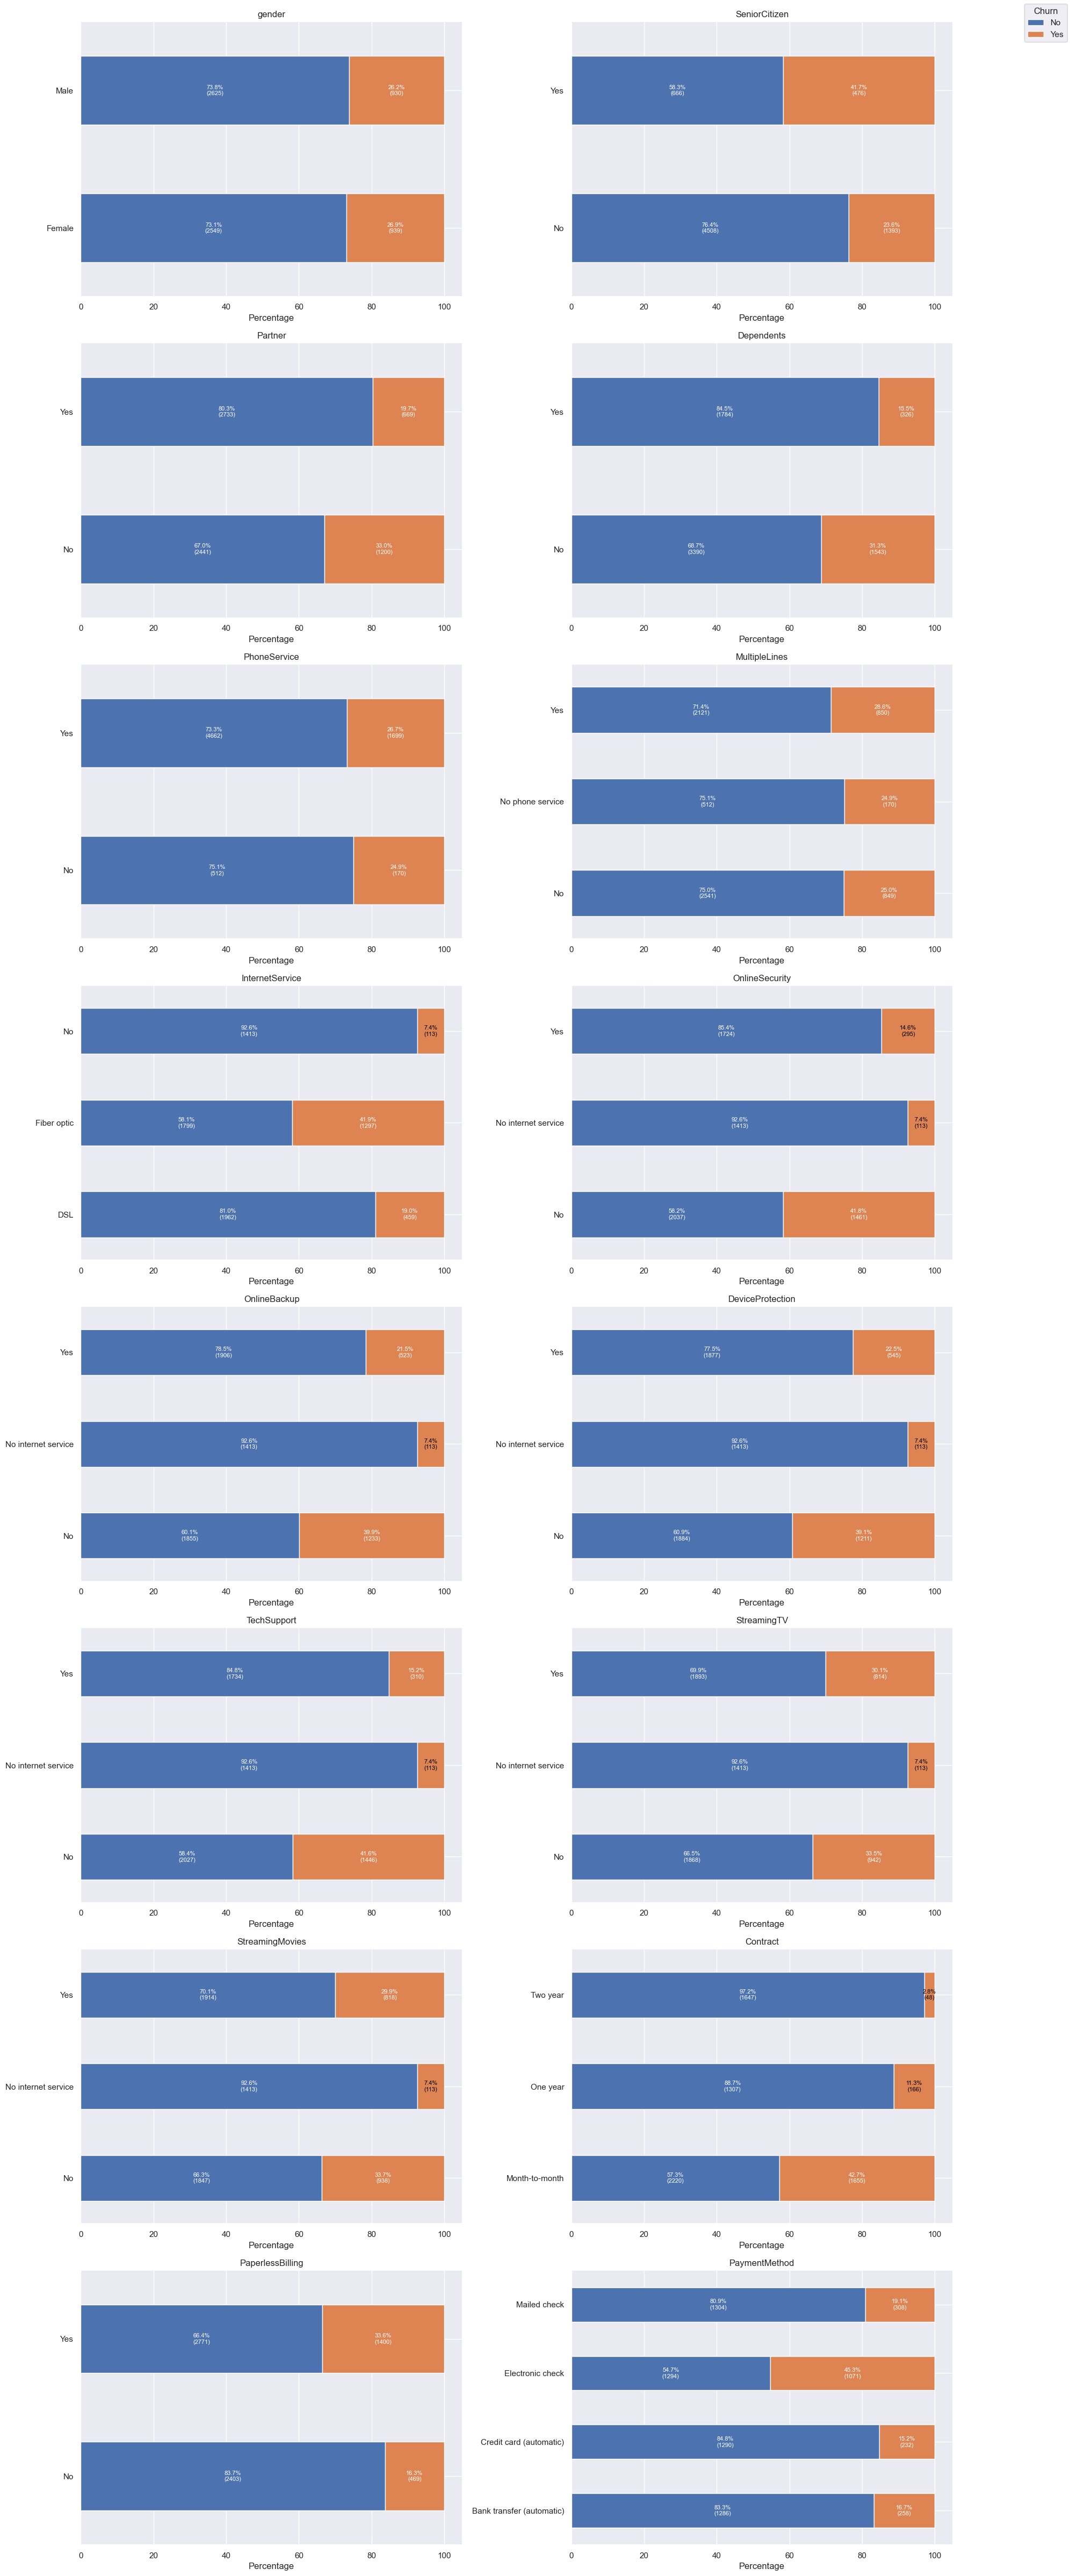

In [123]:
categorical_cols = df.select_dtypes(include='category').columns.drop('Churn')

num_plots = len(categorical_cols)
cols = 2
rows = (num_plots + 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols * 10, rows * 6))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    ax = axes[i]
    
    # Compute counts per category and churn status with observed=True
    counts = df.groupby([col, 'Churn'], observed=True).size().unstack(fill_value=0)
    
    # Convert counts to percentages per category level (row-wise)
    percentages = counts.div(counts.sum(axis=1), axis=0) * 100
    
    # Plot horizontal stacked bar chart on the subplot axis
    percentages.plot(kind='barh', stacked=True, ax=ax, legend=False)
    
    ax.set_title(f'{col}')
    ax.set_xlabel('Percentage')
    ax.set_ylabel('')
    
    # Annotate each segment with percentage and count
    for j, (index, row) in enumerate(percentages.iterrows()):
        cum_width = 0
        for churn_status in percentages.columns:
            pct = row[churn_status]
            cnt = counts.loc[index, churn_status]
            if pct > 0:
                label = f'{pct:.1f}%\n({cnt})'
                ax.text(cum_width + pct / 2, j, label, ha='center', va='center', fontsize=8,
                        color='white' if pct > 15 else 'black')
                cum_width += pct

# Remove any unused subplots
for k in range(i + 1, len(axes)):
    fig.delaxes(axes[k])

# Create one legend for all plots
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title='Churn', loc='upper right')

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space on right for legend
plt.show()

...

## 2.6 Numerical Columns Binning

In [124]:
df['tenure_bin'], tenure_bins = pd.qcut(df['tenure'], q=4, labels=[1, 2, 3, 4], retbins=True)
df['MonthlyCharges_bin'], monthly_bins = pd.qcut(df['MonthlyCharges'], q=4, labels=[1, 2, 3, 4], retbins=True)
df['TotalCharges_bin'], total_bins = pd.qcut(df['TotalCharges'], q=4, labels=[1, 2, 3, 4], retbins=True)

def create_intervals(edges):
    intervals = []
    # q1: less than first edge after min
    intervals.append(f"< {edges[1]}")
    # q2, q3, q4: intervals between edges
    for i in range(1, len(edges)-1):
        intervals.append(f"{edges[i]} - {edges[i+1]}")
    return intervals

bin_summary = pd.DataFrame({
    'Bin Col Name': ['Tenure', 'MonthlyCharges', 'TotalCharges'],
    'q1': [f"< {tenure_bins[1]}", f"< {monthly_bins[1]}", f"< {total_bins[1]}"],
    'q2': [f"{tenure_bins[1]} - {tenure_bins[2]}", f"{monthly_bins[1]} - {monthly_bins[2]}", f"{total_bins[1]} - {total_bins[2]}"],
    'q3': [f"{tenure_bins[2]} - {tenure_bins[3]}", f"{monthly_bins[2]} - {monthly_bins[3]}", f"{total_bins[2]} - {total_bins[3]}"],
    'q4': [f"{tenure_bins[3]} - {tenure_bins[4]}", f"{monthly_bins[3]} - {monthly_bins[4]}", f"{total_bins[3]} - {total_bins[4]}"],
})

display(bin_summary)
display(df.head())

,Bin Col Name,q1,q2,q3,q4
0,Tenure,< 9.0,9.0 - 29.0,29.0 - 55.0,55.0 - 72.0
1,MonthlyCharges,< 35.5,35.5 - 70.35,70.35 - 89.85,89.85 - 118.75
2,TotalCharges,< 401.45,401.45 - 1397.475,1397.475 - 3794.7375,3794.7375 - 8684.8


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_bin,MonthlyCharges_bin,TotalCharges_bin
0,7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,1,1,1
1,5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No,3,2,3
2,3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,2,1
3,7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,3,2,3
4,9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,3,1


Dilakukan secara equal frequencies (qcut).

## 2.7 Save Dataset

In [129]:
df.to_csv('../data/telco_data_eda.csv', index=False)